In [27]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "./input/"]).decode("utf8"))
#print(check_output(["ls", "../input/stage1_train/"]).decode("utf8"))

stage1_test
stage1_test.zip
stage1_train
stage1_train.zip



In [28]:
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import os
from tqdm import tqdm
from skimage.transform import resize
%matplotlib inline

In [29]:
# image_heigth = 256
# image_width = 256

# mask_heigth = 256
# mask_width = 256

def get_images_masks(root_dir):

    images = []
    for image_folder in tqdm(os.listdir(root_dir)):
        image_id = image_folder
        image_dir = root_dir + image_folder
        image_file = image_dir + '/images/' + image_id + '.png'
        image = mpimg.imread(image_file)
        height = image.shape[0]
        width = image.shape[1]
        masks = np.zeros((height,width))
        masks_dir = image_dir + '/masks/'
        
        for mask in os.listdir(masks_dir):
            mask_file = masks_dir + mask
            mask = mpimg.imread(mask_file)
            masks = np.add(masks,mask)
        
        images.append({'image_id': image_id, 'image': image,'masks': masks, 'height': height, 'width': width })
        
    return images

def plot_images(rows,cols,images):
    image_index = 0
    fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(30,30), squeeze=False)
    for r in range(rows):
        for c in range(cols):
            ax[r][c].imshow(images[image_index])
            image_index += 1

In [30]:
images = get_images_masks("./input/stage1_train/")

100%|██████████| 670/670 [01:01<00:00, 10.88it/s]


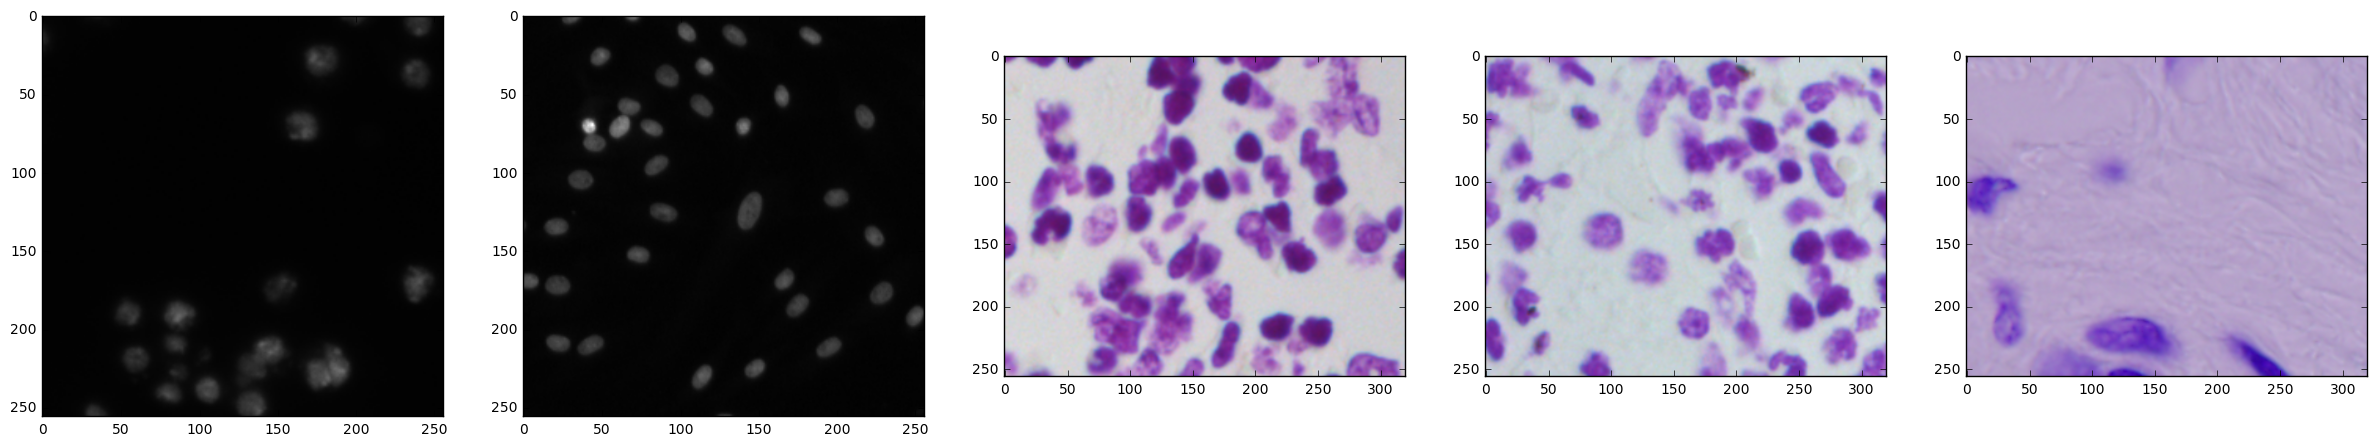

In [31]:
images_array = [image['image'] for image in images]
plot_images(rows=1,cols=5,images=images_array)

In [35]:
## max_height = max([image['height'] for image in images])
#max_width = max([image['width'] for image in images])
    
size = 1408 #max(max_height,max_width)

print(size)


1408


In [36]:
def pad_image(image):
    h_padding = (size - image.shape[0])/2
    w_padding = (size - image.shape[1])/2
    h_ex_pad = 0
    w_ex_pad = 0
    if(image.shape[0] %2 != 0):
        h_ex_pad = 1
    if(image.shape[1] %2 != 0):
        w_ex_pad = 1
    padded_image = np.pad(image,pad_width=((h_padding,h_padding+h_ex_pad),(w_padding,w_padding+w_ex_pad),(0,0)),mode='constant')
    return padded_image

(670, 1408, 1408, 4)


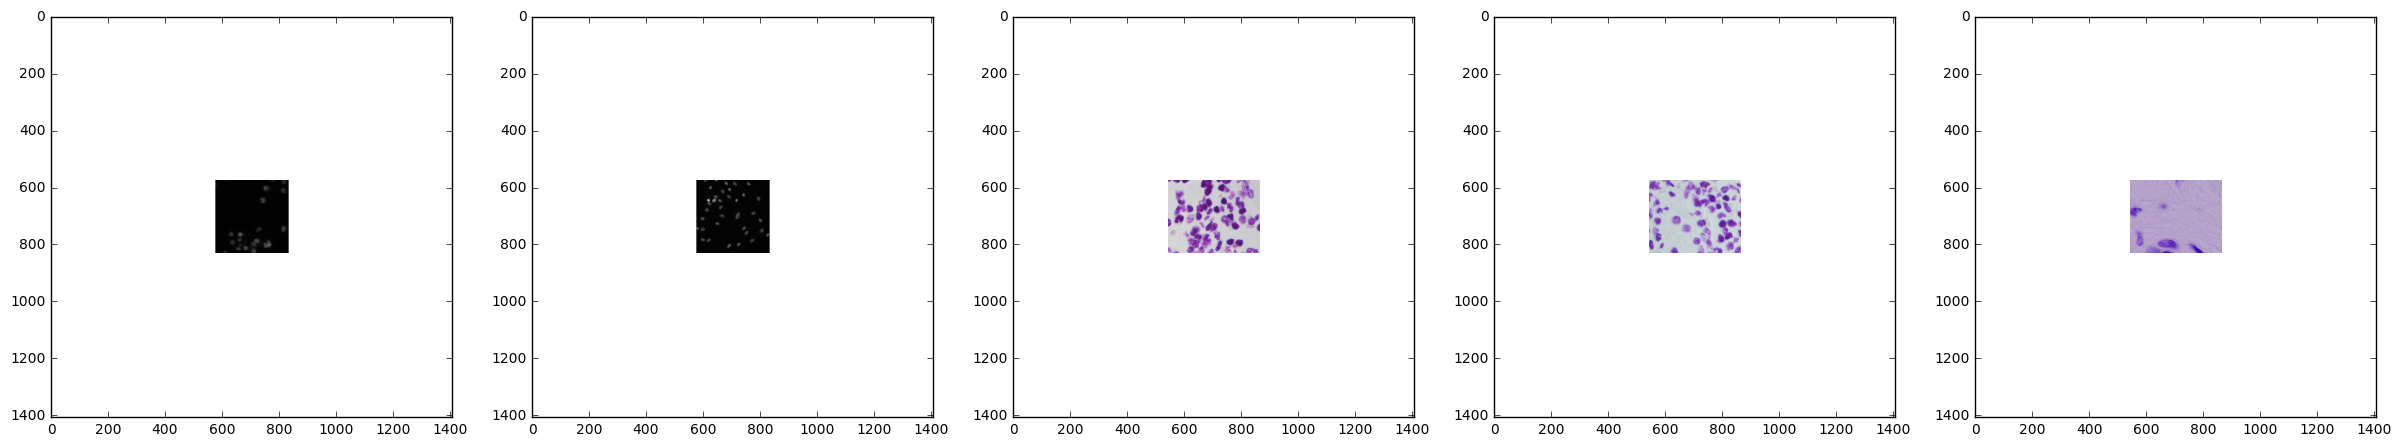

In [37]:
X_train = np.array(map(lambda x: pad_image(x), images_array)).reshape(670,size,size,4)
print(X_train.shape)
plot_images(rows=1,cols=5,images=X_train)

In [38]:
masks_array = [image['masks'].reshape(image['masks'].shape[0],image['masks'].shape[1],1) for image in images]
#plot_images(rows=1,cols=5,images=masks_array[:,:,:,0])

(670, 1408, 1408, 1)


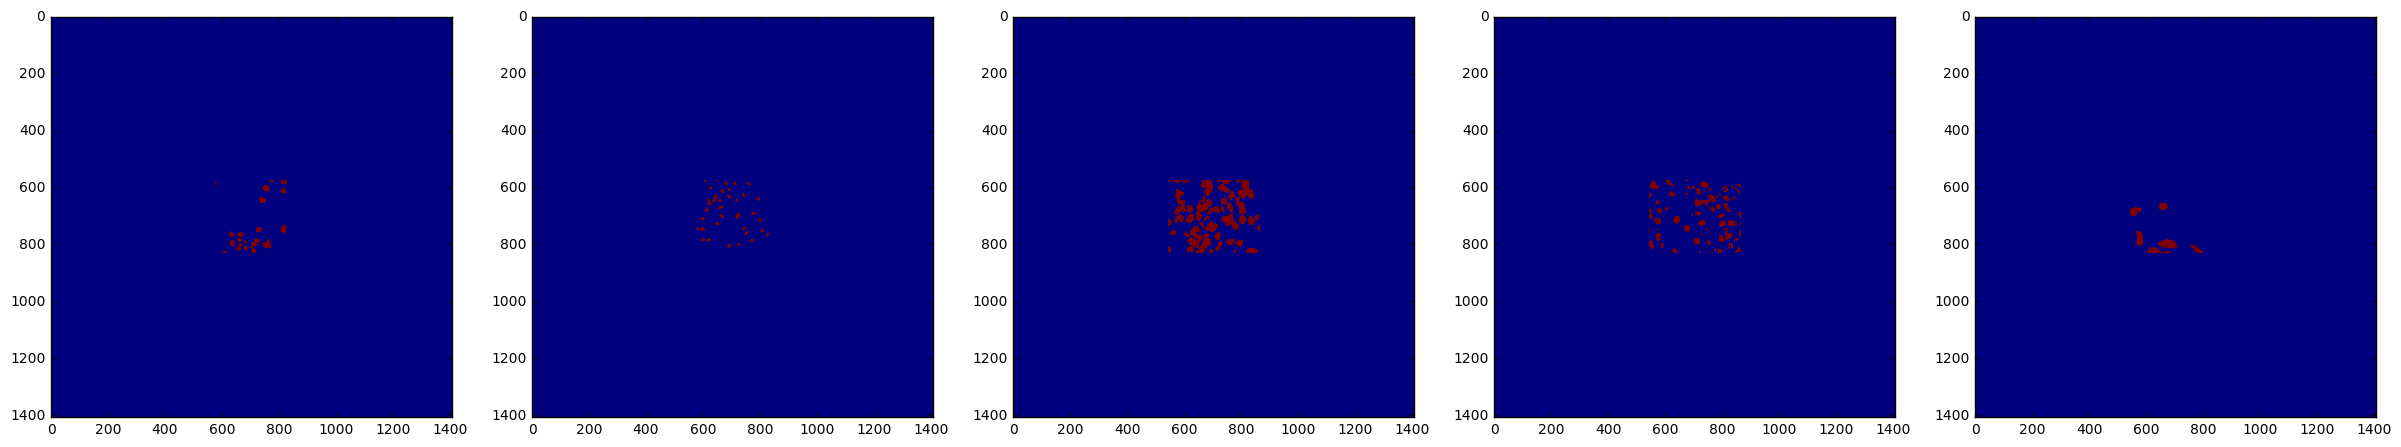

In [39]:
Y_train = np.array(map(lambda x: pad_image(x), masks_array)).reshape(670,size,size,1)
print(Y_train.shape)
plot_images(rows=1,cols=5,images=Y_train[:,:,:,0])

In [40]:
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Cropping2D, Dropout, BatchNormalization
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from keras.optimizers import SGD, Adam

In [43]:
def model(channels):
    X_Input = Input(shape=[1408,1408,4])
    X = Conv2D(filters=8, kernel_size=(3,3),activation='relu', strides=(1,1), padding='same', kernel_initializer='he_normal')(X_Input)
    CX1 = Conv2D(filters=8, kernel_size=(3,3),activation='relu', strides=(1,1), padding='same', kernel_initializer='he_normal')(X)
    #X = Dropout(0.25)(X)
    #X = BatchNormalization()(X)
    
    
    X = MaxPooling2D(pool_size=(2,2), strides=2)(CX1)
    X = Conv2D(filters=16, kernel_size=(3,3),activation='relu', strides=(1,1), padding='same', kernel_initializer='he_normal')(X)    
    CX2 = Conv2D(filters=16, kernel_size=(3,3),activation='relu', strides=(1,1), padding='same', kernel_initializer='he_normal')(X)
    #X = Dropout(0.25)(X)
    #X = BatchNormalization()(X)
    
    
    X = MaxPooling2D(pool_size=(2,2), strides=2)(CX2)    
    X = Conv2D(filters=32, kernel_size=(3,3),activation='relu', strides=(1,1), padding='same', kernel_initializer='he_normal')(X)
    CX3 = Conv2D(filters=32, kernel_size=(3,3),activation='relu', strides=(1,1), padding='same', kernel_initializer='he_normal')(X)
    #X = Dropout(0.25)(X)
    #X = BatchNormalization()(X)
    
    
    X = MaxPooling2D(pool_size=(2,2), strides=2)(CX3)    
    X = Conv2D(filters=64, kernel_size=(3,3),activation='relu', strides=(1,1), padding='same', kernel_initializer='he_normal')(X)
    CX4 = Conv2D(filters=64, kernel_size=(3,3),activation='relu', strides=(1,1), padding='same', kernel_initializer='he_normal')(X)
    #X = Dropout(0.25)(X)
    #X = BatchNormalization()(X)
    
    
    X = MaxPooling2D(pool_size=(2,2), strides=2)(CX4)    
    X = Conv2D(filters=128, kernel_size=(3,3),activation='relu', strides=(1,1), padding='same', kernel_initializer='he_normal')(X)
    X = Conv2D(filters=128, kernel_size=(3,3),activation='relu', strides=(1,1), padding='same', kernel_initializer='he_normal')(X)
    #X = Dropout(0.25)(X)
    #X = BatchNormalization()(X)
    
    X = Conv2DTranspose(filters=512, kernel_size=(2,2), strides=(2,2),activation='relu')(X)
    X = concatenate([X,CX4])
    X = Conv2D(filters=64, kernel_size=(3,3),activation='relu', strides=(1,1), padding='same', kernel_initializer='he_normal')(X)
    X = Conv2D(filters=64, kernel_size=(3,3),activation='relu', strides=(1,1), padding='same', kernel_initializer='he_normal')(X)
    #X = Dropout(0.25)(X)
    #X = BatchNormalization()(X)
    
    X = Conv2DTranspose(filters=32, kernel_size=(2,2), strides=(2,2),activation='relu')(X)
    X = concatenate([X,CX3])
    X = Conv2D(filters=32, kernel_size=(3,3),activation='relu', strides=(1,1), padding='same', kernel_initializer='he_normal')(X)
    X = Conv2D(filters=32, kernel_size=(3,3),activation='relu', strides=(1,1), padding='same', kernel_initializer='he_normal')(X)
    #X = Dropout(0.25)(X)
    #X = BatchNormalization()(X)
    
    X = Conv2DTranspose(filters=16, kernel_size=(2,2), strides=(2,2),activation='relu', kernel_initializer='he_normal')(X)
    X = concatenate([X,CX2])
    X = Conv2D(filters=16, kernel_size=(3,3),activation='relu', strides=(1,1), padding='same', kernel_initializer='he_normal')(X)
    X = Conv2D(filters=18, kernel_size=(3,3),activation='relu', strides=(1,1), padding='same', kernel_initializer='he_normal')(X)
    #X = Dropout(0.25)(X)
    #X = BatchNormalization()(X)
    
    X = Conv2DTranspose(filters=8, kernel_size=(2,2), strides=(2,2),activation='relu', kernel_initializer='he_normal')(X)
    X = concatenate([X,CX1])
    X = Conv2D(filters=8, kernel_size=(3,3),activation='relu', strides=(1,1), padding='same', kernel_initializer='he_normal')(X)
    X = Conv2D(filters=8, kernel_size=(3,3),activation='relu', strides=(1,1), padding='same', kernel_initializer='he_normal')(X)
    #X = Dropout(0.1)(X)
    #X = BatchNormalization()(X)
    
    X = Conv2D(filters=1, kernel_size=(3,3),activation='sigmoid', strides=(1,1), padding='same', kernel_initializer='he_normal')(X)
    
    model = Model(input=[X_Input], output=[X])
    model.summary()
    
    return model

In [44]:
cnn_model = model(channels=4)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 1408, 1408, 4 0                                            
__________________________________________________________________________________________________
conv2d_106 (Conv2D)             (None, 1408, 1408, 8 296         input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_107 (Conv2D)             (None, 1408, 1408, 8 584         conv2d_106[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_25 (MaxPooling2D) (None, 704, 704, 8)  0           conv2d_107[0][0]                 
__________________________________________________________________________________________________
conv2d_108

/Users/lfawaz/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:66: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=[<tf.Tenso...)`


In [ ]:
for i in range(1):
    r = -4 * np.random.rand()
    lr = 0.001#10 ** r
#lr = 0.00040681225534719504
    print("learning rate: ", lr)
    optimizer = Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    cnn_model.compile(optimizer=optimizer,loss='binary_crossentropy')
    earlystopper = EarlyStopping(patience=3, verbose=1)
    csv_logger = CSVLogger('dsBowlTraining_noBN_noDO_lr_' + str(lr) + '.csv')
    model_name = 'dsBowlModel__noBN_noDO_lr_' + str(lr) + '.h5'
    checkpointer = ModelCheckpoint(model_name, verbose=1, save_best_only=True)
    cnn_model.fit(X_train, Y_train, validation_split=0.1, batch_size=32, epochs=1, 
                        callbacks=[checkpointer, earlystopper, csv_logger])
    

('learning rate: ', 0.001)
Train on 603 samples, validate on 67 samples
Epoch 1/1


In [ ]:
type(results1)

In [ ]:
results = load_model('./dsBowlModel__noBN_noDO_lr_0.001.h5')

In [ ]:
Y_train_pred = results.predict(X_train,verbose=1)

In [ ]:
Y_train_pred = (Y_train_pred.reshape(670,mask_heigth,mask_width) > 0.5).astype(int)
plot_images(rows=1,cols=5,images=Y_train_pred)

In [ ]:
Y_train_true = (Y_train_true.reshape(670,mask_heigth,mask_width) > 0.5).astype(int)
plot_images(rows=1,cols=5,images=Y_train_true)

In [ ]:
from scipy import ndimage
from sklearn.metrics import hamming_loss

In [ ]:
def calculate_pixel_error(y_true, y_pred):
    n = len(y_true)
    errors = []
    pixel_length = mask_heigth*mask_width
    for i in range(n):
        error = hamming_loss(y_true[i].flatten(),y_pred[i].flatten())
        errors.append(error)

    pixel_error = np.sum(errors)/n
    
    return pixel_error
        

In [ ]:
print "Traing Pixel Error:", calculate_pixel_error(Y_train_true,Y_train_pred)

In [ ]:
def separate_masks(combined_masks):
    labeled_masks = ndimage.label(combined_masks)
    masks = []
    for i in range(1,labeled_masks[1]+1):
        mask = (labeled_masks[0] == i).astype(int)
        masks.append(mask)
    
    return masks
    

In [ ]:
def identify_postive_pixels(mask):
    mask = mask.T.flatten()
    positive_pixels = []
    for i in range(len(mask)):
        if(mask[i] == 1):
            positive_pixels.append(i+1)
        
    return positive_pixels
    

In [ ]:
def encode_postive_pixels(postive_pixels):
    EncodedPixels = []
    for i in range(len(postive_pixels)):
        if(postive_pixels[i] - 1 in postive_pixels):
            EncodedPixels[-1][1] += 1


        else:                 
            EncodedPixels.append([postive_pixels[i],1])
            
    encodedPixels = ''    
    for item in EncodedPixels:
        for i in item:
            encodedPixels = encodedPixels + str(i) + ' '
           

    return encodedPixels

In [ ]:
image1 = Y_train_pred[0]
#plt.imshow(image1)

masks = separate_masks(image1)
postive_pixels = identify_postive_pixels(masks[0])
encoded_pixels = encode_postive_pixels(postive_pixels)

In [ ]:
print encoded_pixels

In [ ]:
def get_test_images(root_dir,model):
    images = []
    for image_folder in tqdm(os.listdir(root_dir)[1:]):
        image_id = image_folder
        image_dir = root_dir + image_folder
        image_file = image_dir + '/images/' + image_id + '.png'
        
        image = mpimg.imread(image_file) 
        images.append({'image_id': image_id, 'image': image })
    
    return images

In [ ]:
test_images = get_test_images('./stage1_test/','a')

In [ ]:
test_images_array = [image['image'] for image in test_images]
plot_images(rows=1,cols=5,images=test_images_array)

In [ ]:
def create_predicted_masks(images_array,model):
    X_test = []
    for image in images_array:      
        image = resize(image, (image_heigth, image_width, 4), mode='constant', preserve_range=True)
        X_test.append(image)
    
    X_test = np.array(X_test).reshape(65,mask_heigth,mask_width,4)
    Y_test_pred = model.predict(X_test,verbose=1)
    Y_test_pred = (Y_test_pred.reshape(65,mask_heigth,mask_width) > 0.5).astype(int)
    return Y_test_pred

In [ ]:
test_masks = create_predicted_masks(test_images_array,results)

In [ ]:
def resize_image_masks(images_array,masks):
    i = 0
    org_masks = []
    for i in range(len(masks)):
        heigth, width = (images_array[i].shape[0], images_array[i].shape[1])
        mask = resize(masks[i], (heigth, width), mode='constant', preserve_range=True)
        org_masks.append(mask)
        
    return org_masks

In [ ]:
resized_masks = resize_image_masks(test_images_array, test_masks)
plot_images(rows=1,cols=5,images=resized_masks)

In [ ]:
def create_submission_dataFrame(test_images,resized_masks):
    submission = []
    for index in tqdm(range(len(test_images))):
        image_id = test_images[index]['image_id']
        masks = separate_masks(resized_masks[index])
        for j in range(len(masks)):
            postive_pixels = identify_postive_pixels(masks[j])
            encoded_pixels = encode_postive_pixels(postive_pixels)
            submission.append([image_id, encoded_pixels])
    return pd.DataFrame(np.array(submission),columns=['ImageId','EncodedPixels'])

In [ ]:
stage1_test = create_submission_dataFrame(test_images,resized_masks)

In [ ]:
stage1_test.to_csv('stage1_test_labels.csv',index=False)

In [ ]:
LB_Score='0.163'